In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

import sys
sys.path.append('../scripts/')

from proj1_helpers import *
from implementations import *
from costs import *
from plots import *

SEED = 42
DATA_PATH = '/Users/tstadler/Documents/Studies/CS-433/labs/ex05/template/height_weight_genders.csv'

In [3]:
def load_data(data_path, sample_size=500, seed=1):
    """Load data and convert it to the metric system."""
    data = np.genfromtxt(data_path, delimiter=",", skip_header=1, usecols=[1, 2])

    height = data[:, 0]
    weight = data[:, 1]
    gender = np.genfromtxt(data_path, delimiter=",", skip_header=1, usecols=[0], 
                           converters={0: lambda x: 0 if b"Male" in x else 1})
    
    # Convert to metric system
    height *= 0.025
    weight *= 0.454
    
    # Cast into arrays
    y = gender
    x = np.c_[height.reshape(-1), weight.reshape(-1)]
    
    # Subsample
    np.random.seed(seed)
    num_observations = y.shape[0]
    random_permuted_indices = np.random.permutation(num_observations)
    y = y[random_permuted_indices]
    x = x[random_permuted_indices]
    y = y[:sample_size]
    x = x[:sample_size]
    
    x, mean_x, std_x = standardise(x)
    
    return y, x

In [10]:
def encode_data_lr(y,x):
    ty = y.copy()
    ty[ty == -1] = 0
    
    tx = np.c_[np.ones(len(y)), x]
    
    return ty, tx

In [5]:
def eval_model(y, x, w, thresh=0):
    y_pred = predict_labels(w, x, thresh)
    acc = get_accuracy(y_pred, y)
    
    return acc

In [4]:
y, x = load_data(DATA_PATH, seed=SEED)

# Split into train and evaluation set
(x_train, y_train), (x_eval, y_eval) = train_eval_split(y, x, split_ratio=.7, seed=SEED)

# Least-Squares

In [16]:
def test_least_squares():
    # Get optimal weights under MSE loss
    w, loss = least_squares(y_train, x_train)
    print(f'Training loss: {loss}')
    
    acc_train = eval_model(y_train, x_train, w, thresh=0)
    print(f'Training accuracy: {acc_train}')
    
    acc_test = eval_model(y_eval, x_eval, w, thresh=0)
    print(f'Testing accuracy: {acc_test}')

test_least_squares()

Training loss: 0.18097245052318214
Training accuracy: 0.8942857142857142
Testing accuracy: 0.9066666666666666


# Ridge Regression

Maximum test accuracy 0.9051724137931034 with lambda 0.006158482110660254

Training loss: 0.18107278351177972
Training accuracy: 0.9028571428571428
Test accuracy: 0.9066666666666666


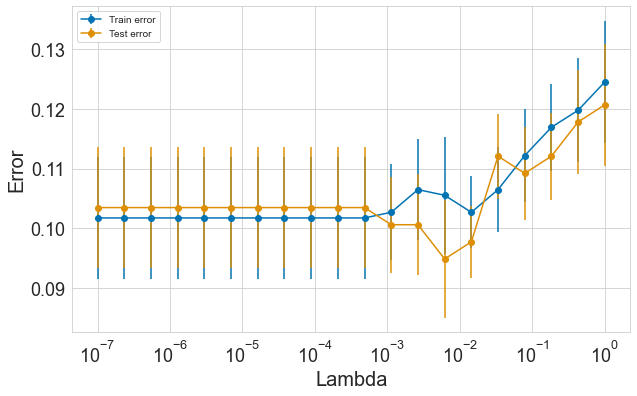

In [18]:
def test_ridge(lambdas, k_fold):
    
    # Hyperparameter optimisation
    acc_train = np.empty((len(lambdas), k_fold), float)
    acc_test = np.empty((len(lambdas), k_fold), float)

    for l, lambda_ in enumerate(lambdas):
        k = 0
        for train_split, test_split in k_fold_iter(y_train, x_train, k_fold):
            # Train
            w, loss = ridge_regression(train_split[1], train_split[0], lambda_)
            acc_tr = eval_model(train_split[1], train_split[0], w)
            acc_train[l, k] = acc_tr

            # Test
            acc_te = eval_model(test_split[1], test_split[0], w)
            acc_test[l, k] = acc_te

            k += 1
    fig = cross_validation_visualization(lambdas, 1-acc_train, 1-acc_test)

    avg_acc_test = np.mean(acc_test, axis=1)
    lambda_opt = lambdas[np.argmax(avg_acc_test)]

    print('Maximum test accuracy {} with lambda {}\n'.format(np.max(avg_acc_test), lambda_opt))
    
    # Run training
    w, loss = ridge_regression(y_train, x_train, lambda_opt)
    print(f'Training loss: {loss}')
    
    acc = eval_model(y_train, x_train, w)
    print(f'Training accuracy: {acc}')
    
    acc = eval_model(y_eval, x_eval, w)
    print(f'Test accuracy: {acc}')

lambdas = np.logspace(-7, 0, 20)
k_fold = 4

test_ridge(lambdas, k_fold)

# Logistic Regression

In [20]:
def test_logistic(gamma):
    
    max_iters = 10000
    
    ty_train, tx_train = encode_data_lr(y_train, x_train)
    w_initial = np.zeros(tx_train.shape[1])

    # Run gradient descent under MSE loss to find optimal weights
    w, loss = logistic_regression(ty_train, tx_train, w_initial, max_iters, gamma, verbose=True)
    print(f'\nTraining loss: {loss}')
    
    acc_train = eval_model(y_train, tx_train, w, thresh=0.5)
    print(f'Training accuracy: {acc_train}')
    
    ty_eval, tx_eval = encode_data_lr(y_eval, x_eval)
    acc_test = eval_model(y_eval, tx_eval, w, thresh=0.5)
    print(f'Testing accuracy: {acc_test}')

test_logistic(0.01)

Gradient Descent (0/9999): loss=106.89876336417497, gradient=175.9176996867318
Gradient Descent (100/9999): loss=81.51151634925893, gradient=1.2400871335835708
Gradient Descent (200/9999): loss=81.02306893735451, gradient=0.30718557811386427
Gradient Descent (300/9999): loss=80.98984843736767, gradient=0.08603496182477562
Gradient Descent (400/9999): loss=80.9871724034297, gradient=0.024873396154775743
Gradient Descent (500/9999): loss=80.98694704589076, gradient=0.0072559360974283164
Gradient Descent (600/9999): loss=80.98692782676474, gradient=0.0021221777225474314
Gradient Descent (700/9999): loss=80.98692618168845, gradient=0.0006211549033304769
Loss convergence:Terminate because loss did not change by more than threshold.

Training loss: 80.9869260674312
Training accuracy: 0.8914285714285715
Testing accuracy: 0.9066666666666666


# Regularised Logistic Regression

Maximum test accuracy 0.896551724137931 with lambda 0.03359818286283781
Gradient Descent (0/4999): loss=89.33187899433241, gradient=2.2758144636929023
Gradient Descent (100/4999): loss=87.0660437926858, gradient=0.02013094465451561
Gradient Descent (200/4999): loss=87.04696541309573, gradient=0.00021222489965424718
Gradient Descent (300/4999): loss=87.04676443950089, gradient=2.2383573799459e-06
Loss convergence:Terminate because loss did not change by more than threshold.
Training accuracy: 0.9057142857142857
Test accuracy: 0.9


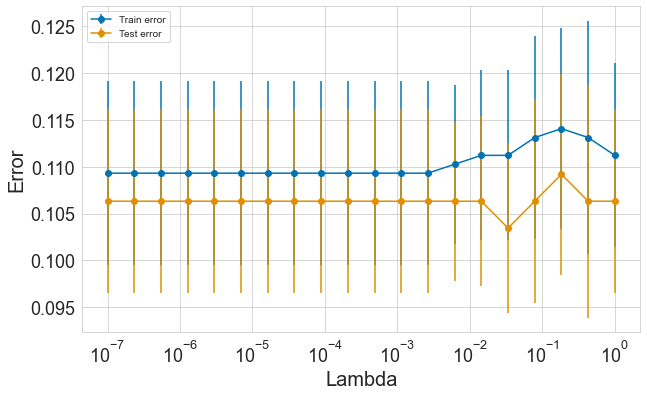

In [13]:
def test_logreg_reg(lambdas, k_fold, gamma):
    max_iters = 5000
    # Hyperparameter optimisation
    acc_train = np.empty((len(lambdas), k_fold), float)
    acc_test = np.empty((len(lambdas), k_fold), float)
    
    ty_train, tx_train = encode_data_lr(y_train, x_train)
    w_initial = np.zeros(tx_train.shape[1])
    
    for l, lambda_ in enumerate(lambdas):
        k = 0
        for train_split, test_split in k_fold_iter(ty_train, tx_train, k_fold):
            # Train
            w, loss = reg_logistic_regression(train_split[1], train_split[0], lambda_, 
                                          w_initial, max_iters, gamma, verbose=False)
            acc_tr = eval_model(train_split[1], train_split[0], w, thresh=0.5)
            acc_train[l, k] = acc_tr

            # Test
            acc_te = eval_model(test_split[1], test_split[0], w, thresh=0.5)
            acc_test[l, k] = acc_te

            k += 1
    fig = cross_validation_visualization(lambdas, 1-acc_train, 1-acc_test)

    avg_acc_test = np.mean(acc_test, axis=1)
    lambda_opt = lambdas[np.argmax(avg_acc_test)]

    print('Maximum test accuracy {} with lambda {}'.format(np.max(avg_acc_test), lambda_opt))
    
    # Run training
    w, loss = reg_logistic_regression(ty_train, tx_train, lambda_, 
                                          w_initial, max_iters, gamma, verbose=True)
    acc = eval_model(ty_train, tx_train, w)
    print(f'Training accuracy: {acc}')
    
    ty_eval, tx_eval = encode_data_lr(y_eval, x_eval)
    acc = eval_model(ty_eval, tx_eval, w)
    print(f'Test accuracy: {acc}')

lambdas = np.logspace(-7, 0, 20)
k_fold = 4

test_logreg_reg(lambdas, k_fold, gamma=0.01)